# South Korean Team Analysis

### Re-runable code for team names and top players in the StatsBomb data sets.

Basic team analysis on StatsBomb free data. This considers all .JSON files within the free data collection so that team name variable can be replaced with any other team from the 2018 FIFA World Cup. In this example, South Korea is used.


In [1]:
# import relevant libraries
%matplotlib inline
import json
import matplotlib as plt; plt.rcdefaults()
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from pitch import draw_pitch,pitch # pitch.py file use as: draw_pitch(7,5)
from functools import reduce

---------

## Find all South Korea match files

1. Get all files in `/data/` directory;
2. Read JSON and concatenate all matches into pre-defined data frame;
3. Create data frame where team_name = @team_name

In [2]:
# step up directory, go to data
os.chdir('..')
path=os.getcwd()+'/data/raw/events/'
print(path)

/Users/steven/Documents/Developer/projects/football-science/data/raw/events/


In [3]:
# get all files in directory
def get_files(path):
    x = os.listdir(path)
    return [os.path.splitext(i)[0] for i in x] 

In [4]:
data_id = get_files(path)

# read the json files and concatenate into a dataframe
all_korea = pd.DataFrame()
for i in data_id:
    with open(path + str(i) + '.json') as data_file:
        data = json.load(data_file)
    df = json_normalize(data, sep = '_')
    if all_korea.empty:
        all_korea = df
    else:
        all_korea = pd.concat([all_korea, df], join = 'outer', sort = False)

In [5]:
all_korea = all_korea[all_korea.team_name == "South Korea"]

In [6]:
# count total number of dribble
total_dribble = all_korea.groupby('player_name')['type_name'].apply(lambda x:(x=='Dribble').sum()).reset_index(name='total_dribble')

# number of dribble completed
dribble_complete = all_korea.groupby('player_name')['dribble_outcome_name'].apply(lambda x: (x=='Complete').sum()).reset_index(name='dribble_completed')

# total number of pass
total_pass = all_korea.groupby('player_name')['type_name'].apply(lambda x: (x=='Pass').sum()).reset_index(name='total_pass')

# number of incomplete pass
pass_incomplete = all_korea.groupby('player_name')['pass_outcome_name'].count().reset_index(name='incomplete_pass')

# number of times being dispossessed
dispossessed = all_korea.groupby('player_name')['type_name'].apply(lambda x: (x=='Dispossessed').sum()).reset_index(name='dispossessed')

In [7]:
df_list = [total_dribble,
           dribble_complete,
           total_pass,
           pass_incomplete,
           dispossessed]

summary_data = reduce(lambda x,y : pd.merge(x,y, on = 'player_name'), df_list)

summary_data.head()

,player_name,total_dribble,dribble_completed,total_pass,incomplete_pass,dispossessed
0,Chul Hong,2,1,36,14,0
1,Hee-Chan Hwang,11,6,34,18,2
2,Heung-Min Son,17,12,79,15,7
3,Hyun-Soo Jang,1,1,95,16,0
4,Hyun-Woo Cho,0,0,63,28,0


---------------------------------

## Visualising Ball Distribution Inefficiency 

The following section measures the passing efficiency of the South Korean team. Firstly, we take the dispossessions, depicted by $x$, plus the incomplete passes, $y$, divided by total passes attempted minus one, $z-1$.

$$\sum_{i=1}^{n}score = \frac{x_i + y_i}{z_i - 1}$$

Text(0.5, 1.0, 'Passing Inefficiency')

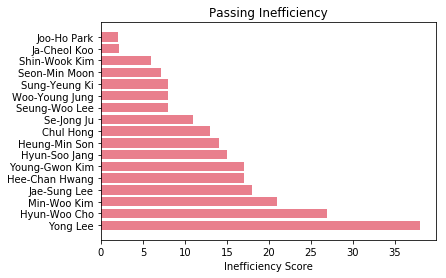

In [8]:
# create the weighted score data.frame
score = {
    'id' : summary_data['player_name'],
    'score' : summary_data['incomplete_pass'] 
            + summary_data['dispossessed'] 
            / summary_data['total_pass'] - 1 }

# assign and sort
calculated_scores=pd.DataFrame(score,columns=['id','score'])
calculated_scores=calculated_scores.sort_values(by='score',ascending=0)

# remove players with < 0 score
calculated_scores.drop(calculated_scores[calculated_scores.score <= 0].index, inplace=True)

# plot
objects=(list(calculated_scores['id']))
y_pos=np.arange(len(objects))
metric=np.array(calculated_scores['score'])

plt.barh(y_pos,metric,align='center',alpha=0.5,color='#D4011D')
plt.yticks(y_pos,objects)
plt.xlabel('Inefficiency Score')
plt.title('Passing Inefficiency')

Next, let's take a look at locations and distance of the misplaced passes, excluding set-pieces and highlighting recoveries.

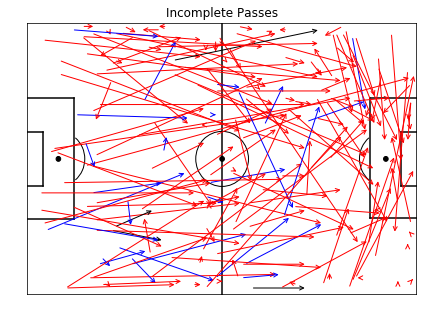

In [9]:
# get incomplete passes
pass_data = all_korea[(all_korea['type_name'] == "Pass") 
                      & (all_korea['pass_outcome_name'] =='Incomplete')
                      & (all_korea['pass_type_name'] != 'Goal Kick') 
                      & (all_korea['pass_type_name'] != 'Corner')
                      & (all_korea['pass_type_name'] != 'Throw-in') 
                      & (all_korea['pass_type_name'] != 'Free Kick')]

fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
pitch(ax)
plt.axis('off')

for i in range(len(pass_data)):
    # differentiate by colour
    if pass_data.iloc[i]['pass_type_name'] == 'Interception':
        color = "black"
    elif pass_data.iloc[i]['pass_type_name'] == 'Recovery':
        color = "blue"
    else:
        color = "red"
        
    #
    ax.annotate("", xy = (pass_data.iloc[i]['pass_end_location'][0], 
                          pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
           xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
           arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = color),)
plt.ylim(0, 80)
plt.xlim(0, 120)
plt.title('Incomplete Passes')
plt.show()

--------------------------------------------------------------------------------

## Modeling

From the above exploratory data analysis, we noticed many incomplete passes are quite long. This lead me to question the relationship between the length of pass and the chance that is would be incomplete. Since the problem is not determining a continuous quantitative outcome but rather a discrete binary outcome, we will use clustering.

In [10]:
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

Preparing the data by manipulating from the raw format into a manageable data frame.

In [111]:
pass_length_outcome.reindex

# get pass length and the outcome
passing_set = all_korea[['pass_length', 
                         'duration', 
                         'pass_angle',
                         'pass_height_id',
                         'pass_height_name',
                         'pass_outcome_name']]

pass_length_outcome = all_korea[['pass_length', 
                                 'duration', 
                                 'pass_angle',
                                 'pass_height_id',
                                 'pass_height_name',
                                 'pass_outcome_name']]

# remove pass lengths <= 0 
pass_length_outcome = pass_length_outcome[pass_length_outcome['pass_length']>0]

# make NaNs = 1 (complete pass)
pass_length_outcome['pass_outcome_name'] = pass_length_outcome['pass_outcome_name'].fillna(1)

# convert outcomes to 0/1 indicating fail or success
pass_length_outcome['pass_outcome_name'] = pass_length_outcome['pass_outcome_name'].map(lambda x: 1 if x==1 else 0)

# cast pass_height_id to int
pass_length_outcome['pass_height_id'] = pass_length_outcome['pass_height_id'].astype(int)

Let's take a look at the data.

In [112]:
pass_length_outcome.head()

,pass_length,duration,pass_angle,pass_height_id,pass_height_name,pass_outcome_name
4,24.331050,1.400,-2.976444,1,Ground Pass,1
6,64.660650,3.266,0.686818,3,High Pass,1
8,7.810250,1.560,-0.694738,2,Low Pass,0
13,16.155495,1.960,1.190290,2,Low Pass,1
15,3.000000,0.173,3.141593,3,High Pass,0


### Exploratory Data Analysis

Now that we have a clean dataset, let's perform some EDA. We will begin with visualising in multiple plots.

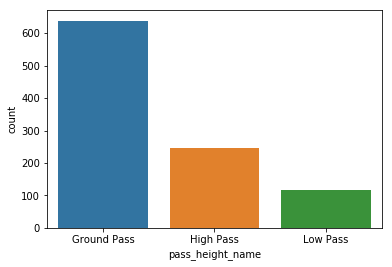

In [113]:
import seaborn as sns

sns.countplot(pass_length_outcome['pass_height_name'],label="Count")
plt.show()

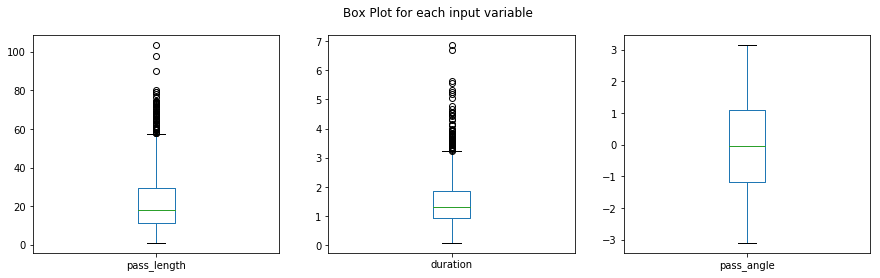

In [114]:
pass_input_variables = pass_length_outcome[['pass_length','duration','pass_angle']]

pass_input_variables.plot(kind='box',
                          subplots=True,
                          layout=(1,3),
                          sharex=False,
                          figsize=(15,4),
                          title='Box Plot for each input variable')

plt.show()

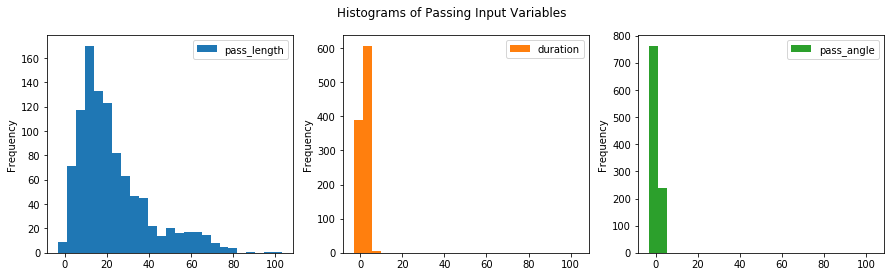

In [127]:
import pylab as pl

pass_input_variables.plot(kind='hist',
                          subplots=True,
                          bins=25,
                          sharex=False,
                          layout=(1,3),
                          figsize=(15,4))
pl.suptitle("Histograms of Input Variables")
plt.show()

Text(0.5, 0.98, '')

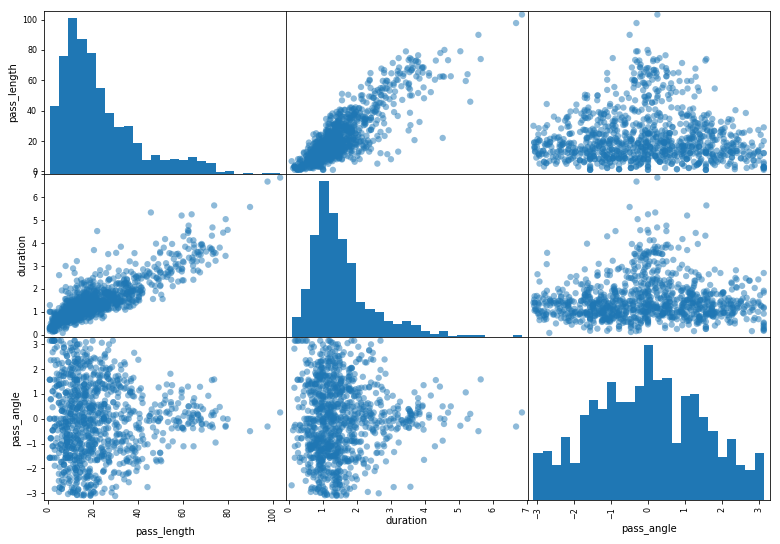

In [128]:
from pandas.plotting import scatter_matrix
from matplotlib import cm

feature_names = list(pass_input_variables.columns)
X = pass_length_outcome[feature_names]
y = list(pass_length_outcome['pass_height_name'].unique())

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, marker = 'o', s = 40, 
                            hist_kwds = {'bins' : 25},
                            figsize = (13,9),
                            cmap = cmap)
plt.suptitle('Scatter Matrix of Input Variables')

In [134]:
pass_input_variables.describe()

,pass_length,duration,pass_angle
count,1001.000000,1001.000000,1001.000000
mean,22.861040,1.534619,-0.043093
std,17.052778,0.923106,1.501082
min,1.000000,0.080000,-3.108272
25%,11.180340,0.933000,-1.176005
50%,18.248287,1.320000,-0.052583
75%,29.681644,1.853000,1.107149
max,103.324730,6.853000,3.141593
